# Optimization Tutorial

Trey V. Wenger (c) October 2024

Here we demonstrate how to optimize the number of cloud components in a `EmissionAbsorptionModel` model.

In [1]:
# General imports    
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi
print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.7.0
caribou_hi version: 1.2.0b0+0.gadf3c86.dirty


## Model Definition and Simulated Data

In [2]:
from bayes_spec import SpecData

# spectral axes definitions
emission_axis = np.linspace(-100.0, 100.0, 500) # km s-1
absorption_axis = np.linspace(-50.0, 50.0, 200) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_emission = 0.1 # K
rms_absorption = 0.01 # optical depth

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
emission = rms_emission * np.random.randn(len(emission_axis))
absorption = rms_absorption * np.random.randn(len(absorption_axis))

dummy_data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)"),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau$"),
}

from caribou_hi import EmissionAbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 2
model = EmissionAbsorptionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp = 3.77, # assumed background temperature (K)
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_tkin=[3.0, 1.0],  # log10(kinetic temp) prior mean and width (K)
    prior_velocity=[0.0, 20.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    prior_rms_emission=0.1,  # width of emission rms (K) prior
    prior_rms_absorption=0.1,  # width of emission rms (K) prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

# Evaluate likelihood for given model parameters
sim_params = {
    "log10_NHI": np.array([20.0, 21.0, 20.5]),
    "log10_depth": np.array([0.5, 2.5, 1.0]),
    "log10_tkin": np.array([2.5, 4.0, 3.5]),
    "velocity": np.array([0.0, -5.0, 5.0]),
    "log10_n_alpha": -6.5,
    "log10_larson_linewidth": 0.1,
    "larson_power": 0.3,
}

sim_params_emission = sim_params.copy()
sim_params_emission["rms_emission"] = rms_emission
sim_params_emission["baseline_emission_norm"] = np.array([-1.0, 2.0, 5.0])

sim_params_absorption = sim_params.copy()
sim_params_absorption["rms_absorption"] = rms_absorption
sim_params_absorption["baseline_absorption_norm"] = np.array([2.0, -2.0, 2.0])

emission = model.model["emission"].eval(sim_params_emission)
absorption = model.model["absorption"].eval(sim_params_absorption)

data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)"),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$\tau$"),
}

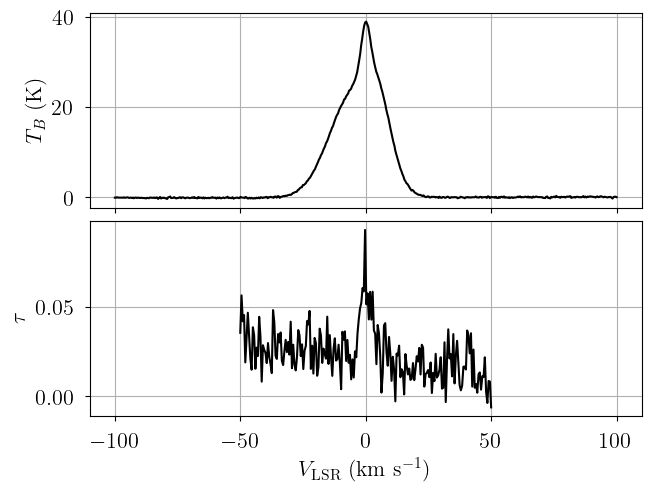

In [3]:
# Plot data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(data["emission"].spectral, data["emission"].brightness, "k-")
axes[1].plot(data["absorption"].spectral, data["absorption"].brightness, "k-")
axes[1].set_xlabel(data["emission"].xlabel)
axes[0].set_ylabel(data["emission"].ylabel)
_ = axes[1].set_ylabel(data["absorption"].ylabel)

## `Optimize`

We use the `Optimize` class for optimization.

In [4]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    EmissionAbsorptionModel,  # model definition
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=2,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_tkin=[3.0, 1.0],  # log10(kinetic temp) prior mean and width (K)
    prior_velocity=[0.0, 20.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    prior_rms_emission=0.1,  # width of emission rms (K) prior
    prior_rms_absorption=0.1,  # width of emission rms (K) prior
    ordered=False,  # do not assume optically-thin
)
opt.add_likelihood()

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [5]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default (`approx=True`), the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. We can supply arguments to `fit` and `sample` via dictionaries. Whichever model is the first to have a BIC within `bic_threshold` of the minimum BIC is the "best" model, and is then sampled with MCMC.

In [6]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.05,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs)

Null hypothesis BIC = 2.899e+06
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 4800
Interrupted at 4,799 [4%]: Average Loss = 2.4155e+05


Output()

n_cloud = 1 BIC = 6.189e+02

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 6100
Interrupted at 6,099 [6%]: Average Loss = 2.9536e+05


Output()

n_cloud = 2 BIC = -9.531e+01

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 9800
Interrupted at 9,799 [9%]: Average Loss = 3.0692e+05


Output()

n_cloud = 3 BIC = -1.375e+03

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 14300
Interrupted at 14,299 [14%]: Average Loss = 1.0346e+05


Output()

n_cloud = 4 BIC = -1.743e+03

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 11400
Interrupted at 11,399 [11%]: Average Loss = 3.3446e+05


Output()

n_cloud = 5 BIC = -1.637e+03

Sampling best model (n_cloud = 4)...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 14300
Interrupted at 14,299 [14%]: Average Loss = 1.0346e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_tkin_norm, velocity_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm, rms_emission_norm, rms_absorption_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1095 seconds.


Adding log-likelihood to trace


Output()

There were 986 divergences in converged chains.
No solution found!
0 of 4 chains appear converged.


The "best" model is saved in `opt.best_model`. Note that the variational inference algorithm has determined that the optimal number of clouds is `n_cloud=4` when, in fact, we generated these data with `n_cloud=3`. Variational inference is only approximation and is ultimately sensitive to the tuning of the hyperparameters! In general, set `approx=False` to sample the posterior distributions of each model with MCMC.

In [7]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
az.summary(opt.best_model.trace.solution_0)

Best model has n_clouds = 4


AttributeError: 'InferenceData' object has no attribute 'solution_0'

Sampling: [absorption, emission]


Output()

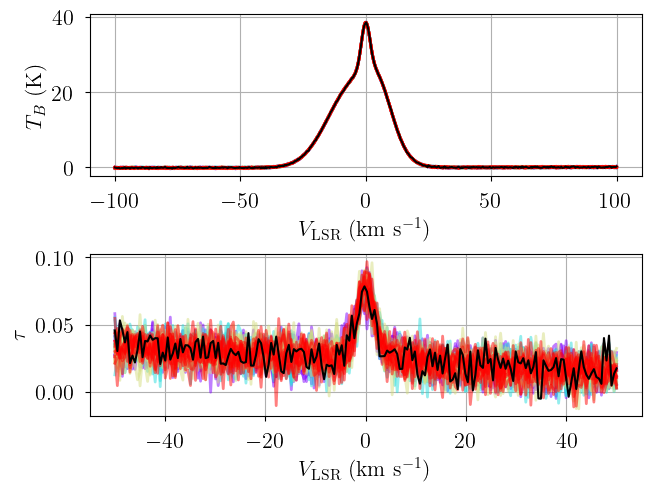

In [10]:
posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(opt.best_model.data, posterior.posterior_predictive)